# 実機でのError Mitigation

このノートブックでは、IBM Quantum Platformの実機を利用し、実機のエラーに対してError Mitigationを行ってみる。

実行するにはIBMのIDが必要となる。また、無料での実機の利用可能時間には上限があるので、実行する場合には気を付けること。

In [ ]:
%pip install qiskit==0.45.2 qiskit-aer==0.12.0
%pip install qiskit-ibm-runtime
%pip install pylatexenc

In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from matplotlib import pyplot as plt
import qiskit

%matplotlib inline

# TゲートのQPE

先ほどの演習で用いたQPEの回路を題材に実行する。

In [2]:
from qiskit.circuit.library import QFT

In [3]:
n_shots = 1024

In [4]:
def make_QFT():
    n_qubits = 4
    circ = QuantumCircuit(n_qubits, 3)

    # 固有ベクトルの入力
    circ.x(3)
    circ.barrier()

    # アダマールゲートの適用
    for i in range(3):
        circ.h(i)
    circ.barrier()

    # 制御ユニタリゲートの適用
    k = 1
    for i in range(3):
        for j in range(k):
            circ.cp(np.pi/4, i, 3);
        k *= 2

    circ.barrier()

    # 逆フーリエ変換
    iqft = QFT(3).inverse().decompose()
    circ = circ.compose(iqft, range(3))

    circ.barrier()

    return circ

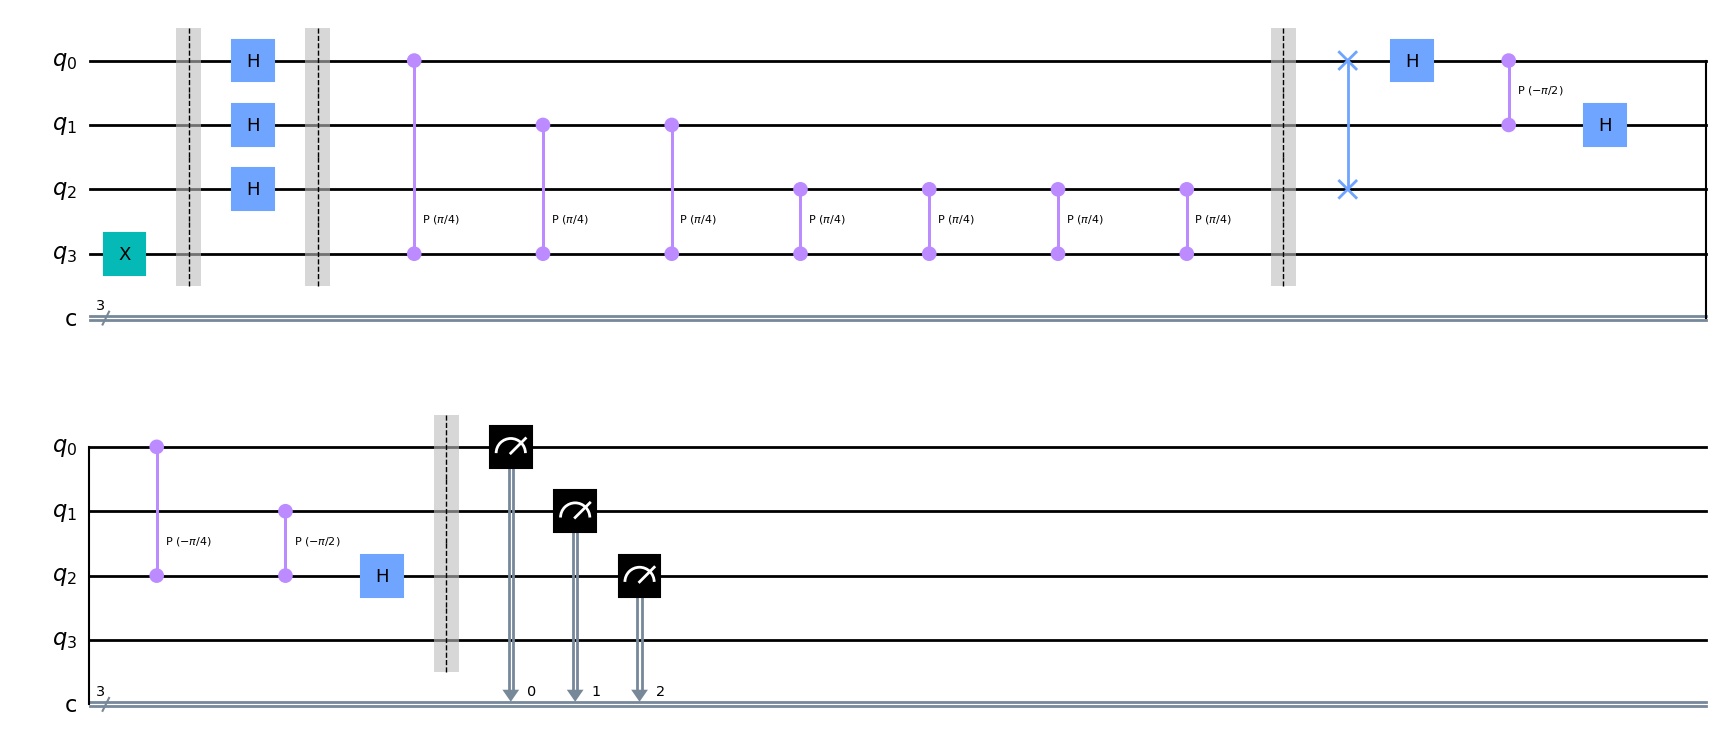

In [6]:
circ = make_QFT()
circ.measure(range(3), range(3))
circ.draw("mpl")

# 実機の準備

以下のtoken欄に、IBM Quantum Platformから得られるAPI keyを入力する。

In [9]:
from qiskit_ibm_runtime import QiskitRuntimeService

# 下記は一度行えばOK
QiskitRuntimeService.save_account(channel="ibm_quantum", token='<MY_IBM_QUANTUM_TOKEN>')

In [10]:
service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True) # 最も空いている実機を選択する
print(backend)

<IBMBackend('ibm_osaka')>


In [11]:
from qiskit_ibm_runtime import Session, Sampler

以下の実行には数分〜数時間かかる。

In [ ]:
with Session(service, backend=backend) as session:
    sampler = Sampler(session=session)
 
    job = sampler.run(circ, shots=n_shots)
    print(f"Job ID: {job.job_id()}")
    print(f"Job result: {job.result()}")

In [13]:
job.result()

SamplerResult(quasi_dists=[{0: 0.033744013560346, 1: 0.771295453994322, 2: 0.021245240734699, 3: 0.060306382351306, 4: 0.014106950958254, 5: 0.041248690060894, 6: 0.01903999537147, 7: 0.039013272968709}], metadata=[{'shots': 1024, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.152851098801496, 'readout_mitigation_time': 0.02472667396068573, 'warning': 'Optimization level clipped from 3 to 1'}])

In [14]:
result = job.result()

In [15]:
result.quasi_dists

[{0: 0.033744013560346, 1: 0.771295453994322, 2: 0.021245240734699, 3: 0.060306382351306, 4: 0.014106950958254, 5: 0.041248690060894, 6: 0.01903999537147, 7: 0.039013272968709}]

## 平均値を取る

In [16]:
def calc_avg(counts):
    total = 0
    for key in counts.keys():
        total += (key / 2**3) * counts[key]
    
    return total

In [17]:
base_score = calc_avg(result.quasi_dists[0])
print(base_score)

0.20558865245811342


In [66]:
def calc_std(counts, n_shots):
    x = []
    for key in counts.keys():
        for _ in range(int(n_shots * counts[key])):
            x.append(key / 2**3) 
            
    std = np.std(x) / np.sqrt(n_shots) # 標準誤差を計算
    return std

In [80]:
base_std = calc_std(result.quasi_dists[0], n_shots)
print(base_std)

0.006196202983623705


# エラー増幅回路

In [31]:
def make_repeated_circ(n_repeat):
    circ = make_QFT()
    
    for _ in range(n_repeat):
        circ = circ.compose(make_QFT().inverse(),range(4))
        circ = circ.compose(make_QFT(),range(4))
    
    circ.measure(range(3), range(3))
    return circ

In [32]:
circ = make_repeated_circ(1)

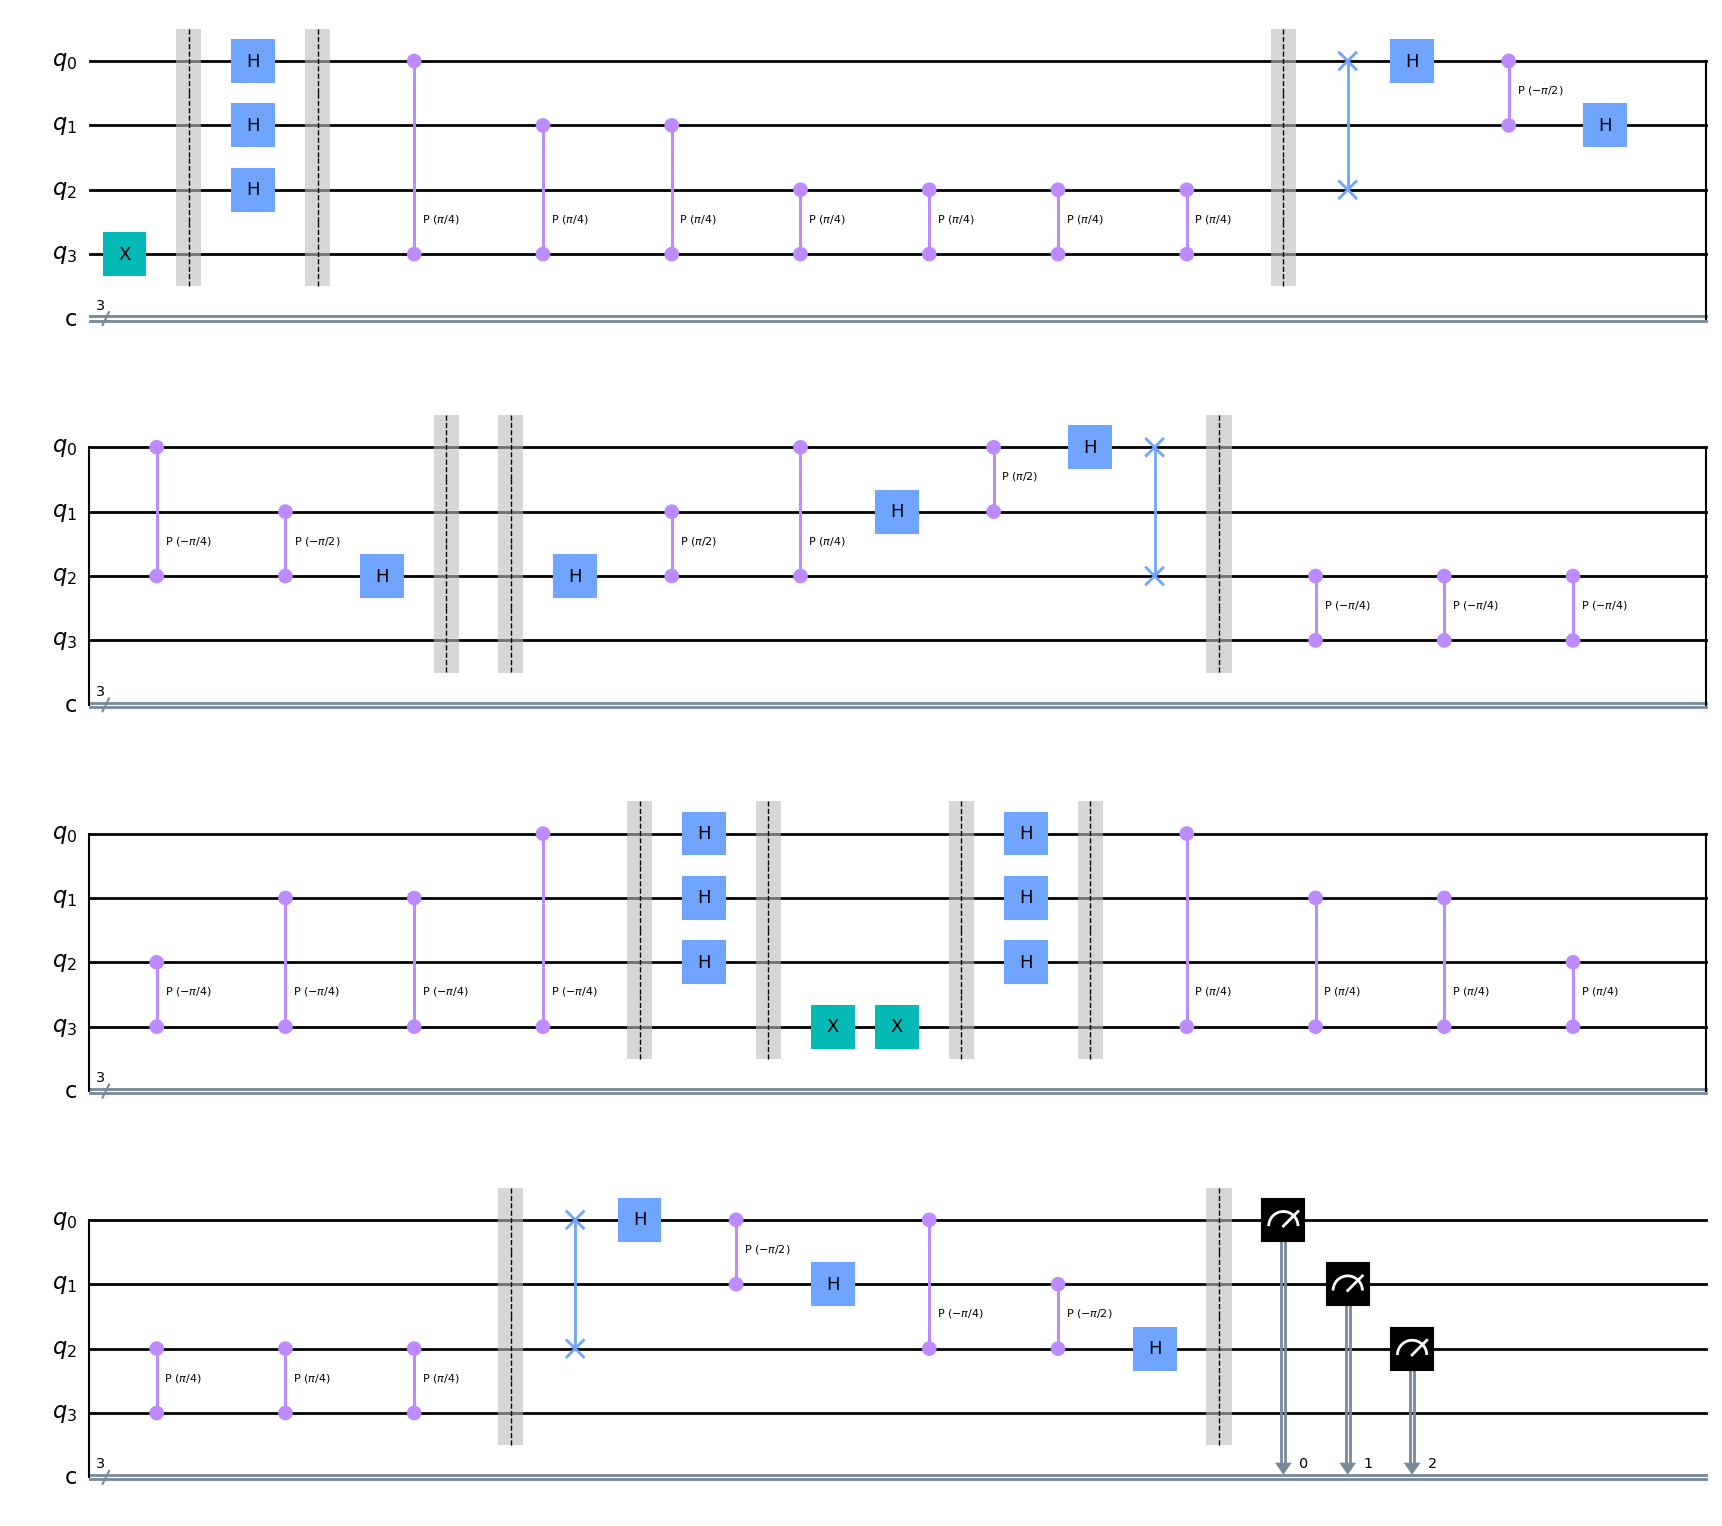

In [33]:
circ.draw("mpl")

In [35]:
def calc_noise_score(circ, n_shots):
    
    with Session(service, backend=backend) as session:
        sampler = Sampler(session=session)
        job = sampler.run(circ, shots=n_shots)

    
    result = job.result()
    noise_score = calc_avg(result.quasi_dists[0])
    noise_std = calc_std(result.quasi_dists[0], n_shots)
    return noise_score, noise_std

実機の待ち時間が長いため、以下では増幅回数は少なめで行う。

In [37]:
circ_length_list = [1]
score_list = [base_score]
std_list = [base_std]
for i in range(1, 4):
    print(f"length: {1 + i*2}") 
    circ = make_repeated_circ(i)
    repeated_noise_score, repeated_noise_std = calc_noise_score(circ, n_shots)
    
    circ_length_list.append(1 + i*2)
    score_list.append(repeated_noise_score)
    std_list.append(repeated_noise_std)

length: 3
length: 5
length: 7


In [38]:
score_list

[0.20558865245811342,
 0.3044251663418507,
 0.35826948390423075,
 0.4015044178068099]

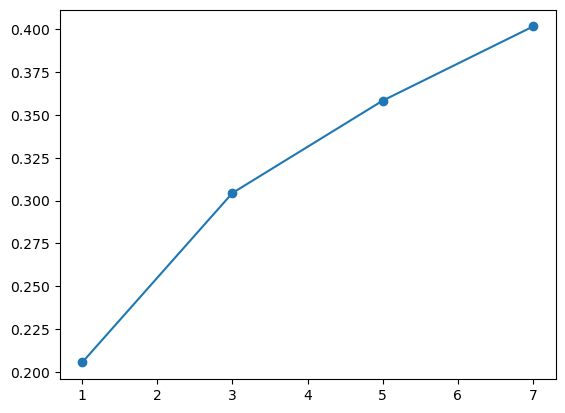

In [39]:
plt.plot(circ_length_list,score_list, "o-")

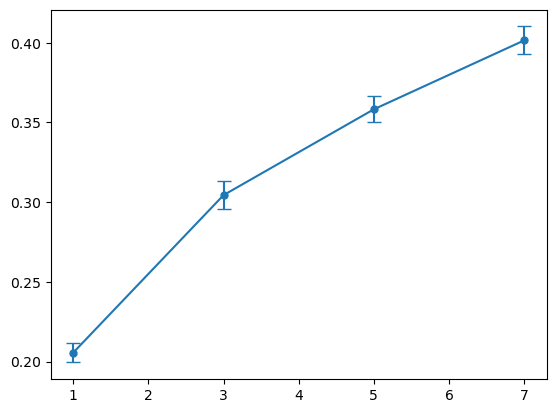

In [77]:
plt.errorbar(x=circ_length_list, y=score_list, yerr=std_list, capsize=5, fmt=".-", markersize=10);

# fitting

In [52]:
from scipy.optimize import curve_fit

def exponential_fitting(x,a,b,c):
    return  a + b*np.exp(x / (x+c))

In [53]:
param_2, _ = curve_fit(exponential_fitting, circ_length_list, score_list, maxfev=100000)

In [54]:
x_arr = np.array([0] + circ_length_list)
fitting_result_2 = [exponential_fitting(x,param_2[0],param_2[1],param_2[2]) for x in x_arr]

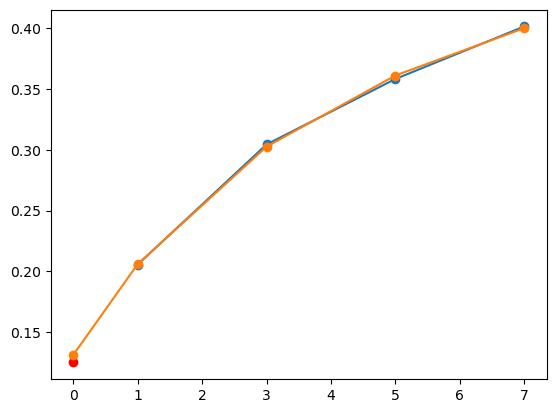

In [79]:
true_score = 1/8
plt.plot(circ_length_list, score_list, "o-")
plt.plot([0]+circ_length_list, fitting_result_2, "o-")
plt.scatter([0],[true_score],c="r")

In [56]:
fitting_result_2[0]

0.13120589991556622

In [57]:
true_score

0.125